In [23]:
# import web driver
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from seleniumrequests import Chrome

from bs4 import BeautifulSoup
import requests
import time
import random
import re
import getpass
import os
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score


%matplotlib inline 

# Crime Data - Clean and Aggregate

#### Clean Crime Data and Save to 'chicago_crime_cleaned_aggregated.csv'

In [2]:
# # Preprocessing Chicago Crime Data

# # Import Chicago Crime Data : Source : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
# df_crime = pd.read_csv("chicago_crime.csv")

# # Convert text date to datetime
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['Date'],format="%m/%d/%Y %I:%M:%S %p", errors = 'coerce')

# # Strip hr, min, sec data so that aggregation per day is possible
# df_crime['DATE_TIME_TRUN'] = df_crime['DATE_TIME'].map(lambda x: x.strftime('%Y-%m-%d'))

# # Drop unneeded columns
# df_crime = df_crime[['ID','DATE_TIME_TRUN']].copy()

# # Just get the date and total crime count and create new df after aggregating by single day
# df_crime = df_crime.groupby(['DATE_TIME_TRUN'],as_index = False).count().copy()

# # Save cleaned data
# with open('chicago_crime_cleaned_aggregated.pkl', 'wb') as picklefile:
#     pickle.dump(df_crime, picklefile)


#### Load Cleaned & Aggregated Crime Data and Few More Tweaking

In [3]:
# # Load data
# with open('chicago_crime_cleaned_aggregated.pkl', 'rb') as picklefile: 
#     df_crime = pickle.load(picklefile)

# # Turn DATE_TIME back to datetime dtype
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['DATE_TIME_TRUN'])
# df_crime['YEAR_MONTH'] = df_crime['DATE_TIME_TRUN'].apply(lambda x:x[:-3])

# # Remove Crime Data Outside Available Weather Data
# df_crime = df_crime[df_crime['DATE_TIME_TRUN']>'2009-09-01'] 

# # Rename Columns to Make Them More Intuitive and for Later Merging with Weather Data
# df_crime.rename(columns={'ID':'CRIME_COUNT','DATE_TIME':'DATE_TIME_PROCESSED'}, inplace=True)

# Weather Data -  Scraping

#### (Testing) scroll length 

In [4]:
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(2,2010)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

#### Web scraping function

In [5]:
# def scrape_weather_url(url):
#     # weather data holder to be inserted to pandas dataframe
#     high_low, weather_desc, humidity_barometer, wind, date_time = [], [], [], [], []
    
#     # open url
#     driver.get(url)
#     soup = BeautifulSoup(driver.page_source, "lxml")
#     days_chain = [x.find_all('a') for x in soup.find_all(class_='weatherLinks')]
#     time.sleep(5)
    
#     # Load Entire Page by Scrolling to charts
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight/3.5);") # Scroll down to bottom
    
#     # First load of each month takes extra long time. Therefore 'counter' variable is used to run else block first
#     counter = 0
#     for ix,link in enumerate(days_chain[0]):
        
#         '''
#         Bottom section tries to solve loading issue by implementing wait feature
#         Refer : https://selenium-python.readthedocs.io/waits.html
#         '''
#         wait = WebDriverWait(driver, 10)
#         if counter!=0:
#             delay = 3 # seconds
#             try:
#                 myElem = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
#             except TimeoutException:
#                 print("Loading took too much time!" ) 
#             day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
#             wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
#             day_link.click()
#         else:
#             delay = 5 # seconds
#             try:
#                 myElem = WebDriverWait(driver, delay).until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
#             except TimeoutException:
#                 print("Loading took too much time!" ) 
#             day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
#             wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
#             time.sleep(4)
#             day_link.click()
#             time.sleep(3)
#             counter+=1
        
#         # Wait a bit for the Javascript to fully load data to be scraped
#         time.sleep(2.5)
            
#         # Scrape weather data
#         high_low.insert(0,driver.find_elements_by_xpath("//div[@class='temp']")[-1].text) #notice elements, s at the end. This returns a list, and I can index it.
#         weather_desc.insert(0,driver.find_element_by_xpath("//div[@class='wdesc']").text)
#         humidity_barometer.insert(0,driver.find_element_by_xpath("//div[@class='mid__block']").text)
#         wind.insert(0,driver.find_element_by_xpath("//div[@class='right__block']").text)
#         date_time.insert(0,driver.find_elements_by_xpath("//div[@class='date']")[-1].text)
#     return high_low, weather_desc, humidity_barometer, wind, date_time

 

#### Iterate through entire list of month&year combo. Remove month&year already scraped from list

In [6]:
# # Initiate Selenium Chrome driver for Mac
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())

# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]

# # remove done items from list of month & year combo that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)

# # iterate through each year & month combo to scrape
# for date in year_month_list_done_removed:
#     # define initial empty dataframe
#     df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})
#     month = int(date[5:])
#     year = date[:4]
#     url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(month,year)
#     high_low, weather_desc, humidity_barometer, wind, date_time = scrape_weather_url(url)
#     df_weather_holder = pd.DataFrame({'DATE_TIME':date_time, 'HIGH_LOW':high_low, 'WEATHER_DESC':weather_desc,'HUMIDITY_BAROMETER':humidity_barometer,'WIND':wind})
#     df_weather = df_weather.append(df_weather_holder)
#     df_weather.to_csv('weather_data/df_weather_{}_{}.csv'.format(month,year),index=False)
    

#### (Troubleshooting) For particular month&year, print scraped data's dataframe and open weather site for comparison

In [72]:
# read_index = 0

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())
# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]
# # remove done items from list of month & year combe that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)
# # Open weather site for that month
# read_month = [x[11:][:-4].split('_') for x in done_list][read_index][0]
# read_year = [x[11:][:-4].split('_') for x in done_list][read_index][1]
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(read_month,read_year)
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

# Weather Data - Clean

#### Clean Weather Data and Save to 'df_weather_clean.csv'

In [7]:
# # Obtain scraped data files per month
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')

# # Initiate empty dataframe for weather data to compile individual files
# df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})

# # Concat all individual files
# for file_name in done_list:
#     file = pd.read_csv('weather_data/'+file_name)
#     df_weather = pd.concat([df_weather,file],ignore_index=True,axis=0)

# # Remove duplicate rows. (Mistake created by earlier code imperfection that was corrected later)
# df_weather.drop_duplicates(inplace=True)

# # Process and create new columns with individual features for further feature engineering
# df_weather['DATE_TIME_PROCESSED'] = df_weather['DATE_TIME'].apply(lambda x : x.split(',')[1]+x.split(',')[2])
# df_weather['DATE_TIME_PROCESSED'] = pd.to_datetime(df_weather['DATE_TIME_PROCESSED'], format = ' %B %d %Y')
# df_weather['T_HIGH_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[0].strip())
# df_weather['T_LOW_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[1].strip().split()[0])
# df_weather['HUMIDITY_%'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[1][:-1])
# df_weather['BAROMETER_HG'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[3])
# df_weather['WIND_DIRECTION'] = df_weather['WIND'].apply(lambda x : x.split()[0])
# df_weather['WIND_MPH'] = df_weather['WIND'].apply(lambda x : x.split()[2])

# # Drop raw columns that contained multiple featuers as texts
# df_weather_processed = df_weather.drop(['DATE_TIME', 'HIGH_LOW','HUMIDITY_BAROMETER', 'WIND'], axis=1)

# # Remove rows for which weather data was not available
# df_weather_processed = df_weather_processed[df_weather_processed['T_HIGH_F']!='N']

# # Turn object dtypes to floats for temperatures, humidity, barometer reading, and wind intensity. 
# convert_to_int_list = ['T_LOW_F','T_HIGH_F','HUMIDITY_%','BAROMETER_HG','WIND_MPH']
# for feature in convert_to_int_list:
#         df_weather_processed[feature] = df_weather_processed[feature].astype(float)

# # Save clean data
# with open('df_weather_clean.pkl', 'wb') as picklefile:
#     pickle.dump(df_weather_processed, picklefile)

#### Read from Saved 'df_weather_clean.pkl'

In [8]:
# # Read the saved file.
# with open('df_weather_clean.pkl', 'rb') as picklefile: 
#     df_weather_processed = pickle.load(picklefile)

# Crime & Weather Data - Merge

#### Merge Crime and Weather Data and Save to 'df_merged.csv'

In [70]:
# # Perform merging to df_weather based on date.
# df_merged = pd.merge(df_weather_processed,df_crime,on='DATE_TIME_PROCESSED',how='left')

# # Drop two columns from df_crime that we don't need
# df_merged = df_merged.drop(['DATE_TIME_TRUN','YEAR_MONTH'],axis=1)

# # Drop NaN values. These are values from df_crime that didn't have data  matching for df_weather. Only first 6 rows removed.
# df_merged = df_merged.dropna()

# # # Save df_merged.pkl
# with open('df_merged.pkl', 'wb') as picklefile:
#     pickle.dump(df_merged, picklefile)

#### Read from Saved 'df_merged.csv'

In [483]:
# Read saved df_merged.pkl
with open('df_merged.pkl', 'rb') as picklefile: 
    df_merged = pickle.load(picklefile)

# Feature Engineering - Numeric

In [484]:
# T_HIGH_F Squared
# Assumption : Identified quadratic behavior of crime count on pair plot
df_merged['T_HIGH_F_SQUARED'] = df_merged['T_HIGH_F']**2

# Day of the week
# Assumption : There might be a pattern with crime and day of the week. ex) people drink more during weekends
df_merged['DAY_NAME'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : x.day_name())

# Date as int
# Assumption : Crime count will go down as time progresses
df_merged['DATETIME_INT'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : int(str(x).split()[0].replace('-','')))

# Moving Average for Each Feature
# Assumption : If it has been consistently hot and/or humid, it might contribute to higher crimes because people are more hot-headed



# Feature Engineering - Categorical

In [485]:
# Add "DAY_NAME" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['DAY_NAME'], drop_first=False)], axis=1)

# # Add "WIND_DIRECTION" categorical feature as numeric features for linear regression
# df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WIND_DIRECTION'], drop_first=False)], axis=1)

# Convert 'WEATHER_DESC' that's less than 84 occurences to 'Others'
weather_desc_count = df_merged['WEATHER_DESC'].value_counts()
other_weather_desc_count = list(weather_desc_count[weather_desc_count <= 84].index)
df_merged['WEATHER_DESC'] = df_merged['WEATHER_DESC'].replace(other_weather_desc_count, 'Other')

# Add "WEATHER_DESC" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WEATHER_DESC'], drop_first=False)], axis=1)

# Drop catagorical columns
df_merged = df_merged.drop(['WEATHER_DESC', 'DATE_TIME_PROCESSED','WIND_DIRECTION','DAY_NAME'], axis=1)
#df_merged = df_merged.drop(['WEATHER_DESC','WIND_DIRECTION','DAY_NAME'], axis=1)



In [486]:
df_merged.head()

,T_HIGH_F,T_LOW_F,HUMIDITY_%,BAROMETER_HG,WIND_MPH,CRIME_COUNT,T_HIGH_F_SQUARED,DATETIME_INT,Friday,Monday,...,Sunday,Thursday,Tuesday,Wednesday,Clear.,Fog.,Mostly cloudy.,Other,Overcast.,Passing clouds.
6,82.0,66.0,65.0,29.85,12.428,751.0,6724.0,20190625,0,0,...,0,0,1,0,0,0,0,0,0,1
7,66.0,63.0,84.0,29.77,6.836,751.0,4356.0,20190625,0,0,...,0,0,1,0,1,0,0,0,0,0
8,72.0,72.0,93.0,29.63,8.700,770.0,5184.0,20190624,0,1,...,0,0,0,0,0,0,0,0,0,1
9,73.0,66.0,72.0,29.96,8.078,784.0,5329.0,20190623,0,0,...,1,0,0,0,0,0,1,0,0,0
10,63.0,63.0,69.0,29.97,6.836,786.0,3969.0,20190622,0,0,...,0,0,0,0,0,0,1,0,0,0


In [487]:
df_merged.dtypes

T_HIGH_F            float64
T_LOW_F             float64
HUMIDITY_%          float64
BAROMETER_HG        float64
WIND_MPH            float64
CRIME_COUNT         float64
T_HIGH_F_SQUARED    float64
DATETIME_INT          int64
Friday                uint8
Monday                uint8
Saturday              uint8
Sunday                uint8
Thursday              uint8
Tuesday               uint8
Wednesday             uint8
Clear.                uint8
Fog.                  uint8
Mostly cloudy.        uint8
Other                 uint8
Overcast.             uint8
Passing clouds.       uint8
dtype: object

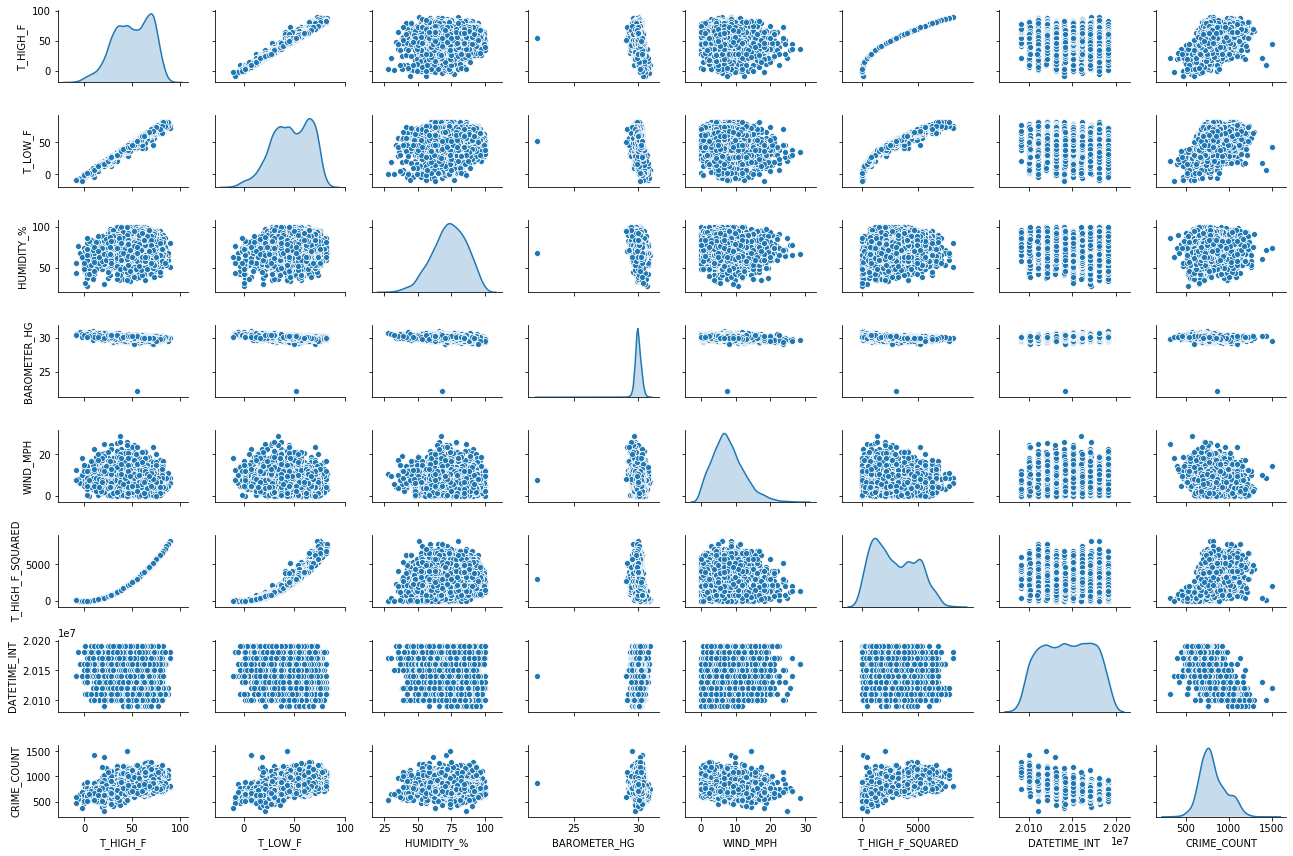

In [490]:
sns.pairplot(df_merged[['T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH', 'T_HIGH_F_SQUARED', 'DATETIME_INT','CRIME_COUNT']],height=1.5, aspect=1.5, diag_kind='kde');

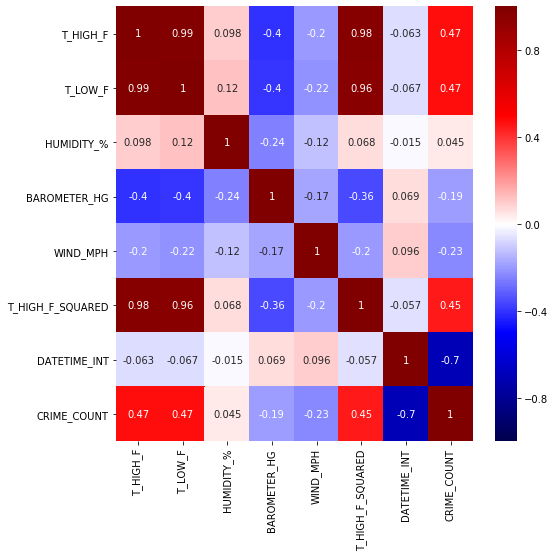

In [491]:
# corr matrix of numerical features
plt.figure(figsize=(8, 8))
sns.heatmap(df_merged[['T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH', 'T_HIGH_F_SQUARED', 'DATETIME_INT','CRIME_COUNT']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

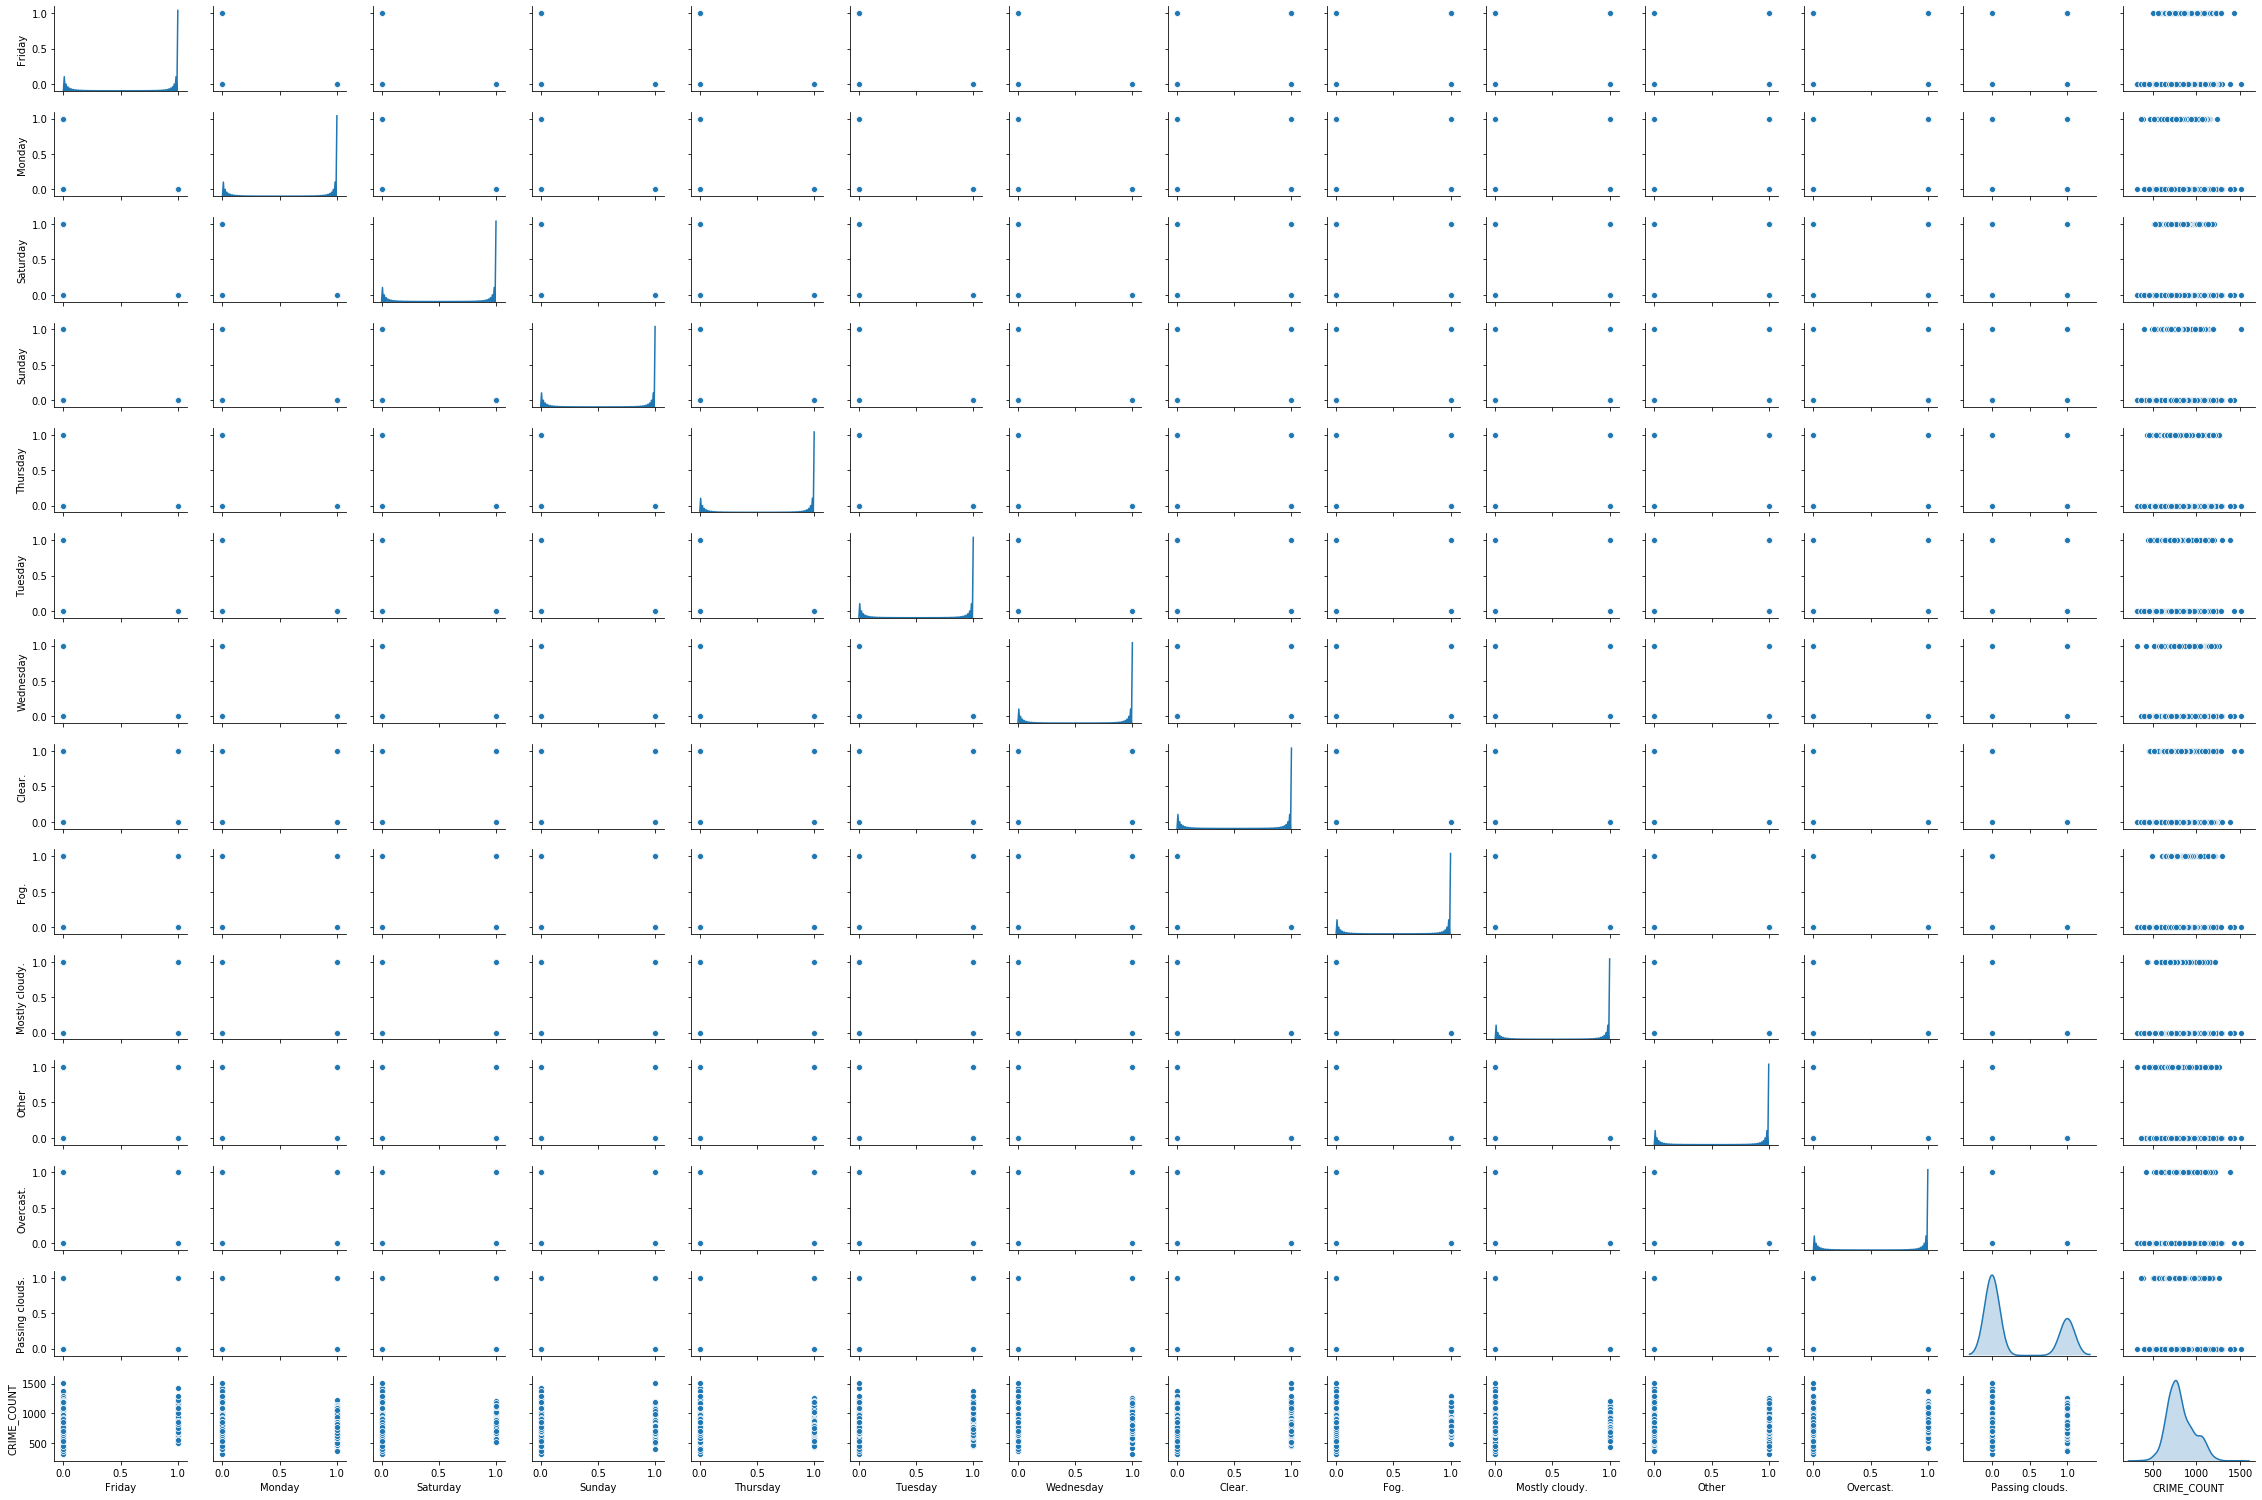

In [493]:
categorical_features = ['Friday', 'Monday','Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Clear.','Fog.', 'Mostly cloudy.', 'Other', 'Overcast.', 'Passing clouds.','CRIME_COUNT']
#sns.pairplot(pd.concat([df_merged[list(df_merged.columns)[7:]], df_merged['CRIME_COUNT']], axis=1), plot_kws=dict(alpha=.1, edgecolor='none'))
sns.pairplot(df_merged[categorical_features],height=1.5, aspect=1.5, diag_kind='kde');

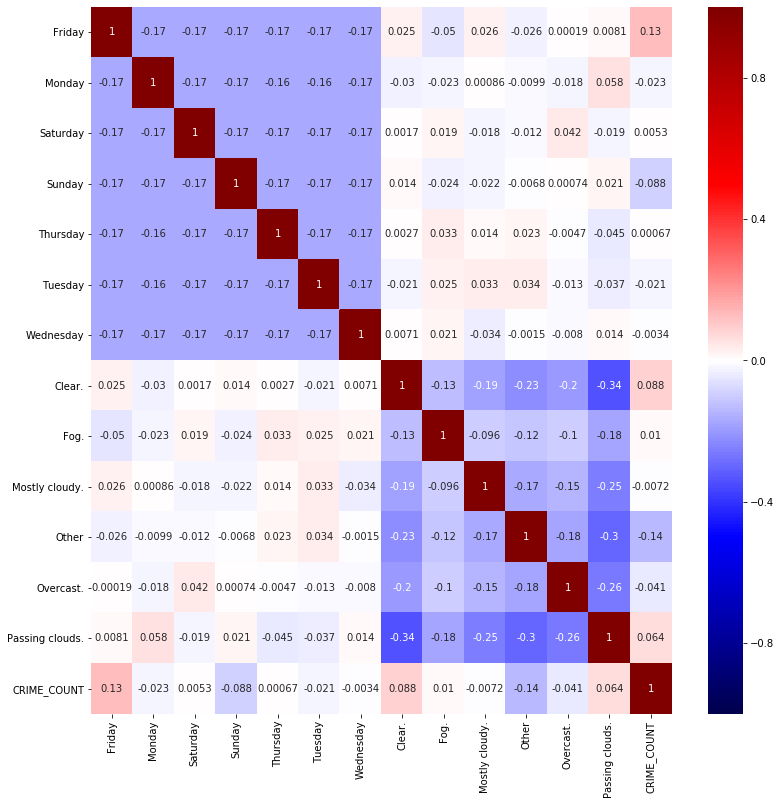

In [494]:
# corr matrix
plt.figure(figsize=(13, 13))
sns.heatmap(df_merged[categorical_features].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

# Residual Plot to Detect Outliers -> Remove Them

# Linear Regression

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful
* 'l1_ratio' = 1 in ElasticNet

**Ridge**:
* _Pro_: great for smoothly handling multicollinearity, very nice when working with sparse features 
* _Con_: will never fully discard features
* 'l1_ratio' = 0 in ElasticNet


#### Graph Functions

In [495]:
def graph_pred_vs_actual(actual,pred,data_type):
    plt.scatter(actual,pred,alpha=.3)
    plt.plot(np.linspace(int(min(pred)),int(max(pred)),int(max(pred))),np.linspace(int(min(pred)),int(max(pred)),int(max(pred))))
    plt.title('Actual vs Pred ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Pred')  
    plt.show()
def graph_residual(actual,residual,data_type):
    plt.scatter(actual,residual,alpha=.3)
    plt.plot(np.linspace(int(min(actual)),int(max(actual)),int(max(actual))),np.linspace(0,0,int(max(actual))))
    plt.title('Actual vs Residual ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Residual')
    plt.show()
        

#### Base Model

In [498]:
#Split the data 80/20 cross-validation/test
# Include Categorical features : ['T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH']
features = list(df_merged.columns[0:5])
target = 'CRIME_COUNT'

X = df_merged[features]
y = df_merged[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state=42)

base_model = LinearRegression()
base_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

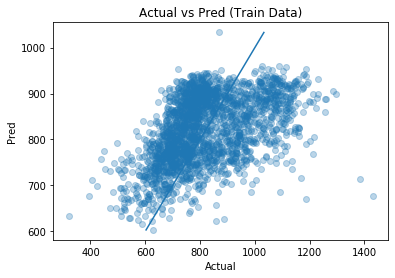

In [499]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_train,base_model.predict(X_train),'Train')

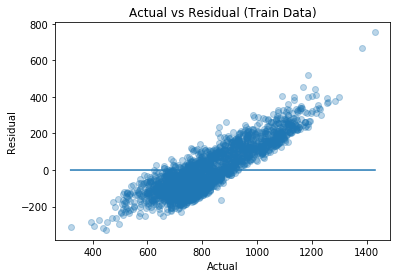

In [500]:
## Residual Plot
graph_residual(y_train,y_train-base_model.predict(X_train),'Train')

In [501]:
base_model.score(X_train,y_train)

0.22928194150629477

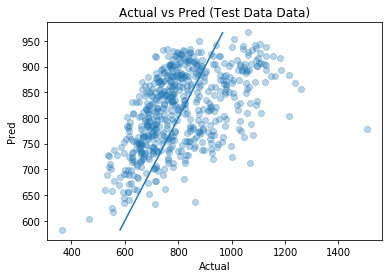

In [502]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,base_model.predict(X_test),'Test Data')

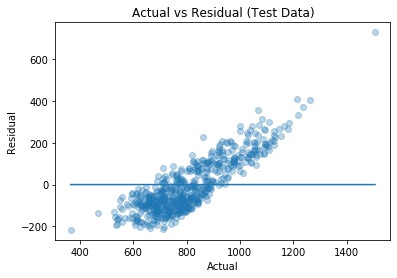

In [503]:
## Residual Plot
graph_residual(y_test,y_test-base_model.predict(X_test),'Test')

In [504]:
base_model.score(X_test,y_test)

0.2771287801331924

In [505]:
list(zip(X_train.columns,base_model.coef_))

[('T_HIGH_F', 1.681290823738953),
 ('T_LOW_F', 1.5741677627180488),
 ('HUMIDITY_%', -0.3831449887703135),
 ('BAROMETER_HG', -24.765762616382332),
 ('WIND_MPH', -5.720860179741845)]

#### ElasticNet - RandomGrid - All Features

In [507]:
#Split the data 80/20 cross-validation/test
features = list(df_merged.columns[0:5].append(df_merged.columns[6:]))
target = 'CRIME_COUNT'

X = df_merged[features]
y = df_merged[target]

X_cross_val, X_test, y_cross_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [508]:
# Define cross-validation pipelines for lasso and ridge linear regression models
elasticnet_pipeline = Pipeline([
                        ('polynomial',PolynomialFeatures()),
                        ('standard',StandardScaler()),                        
                        ('model',ElasticNet())
                        ])

In [509]:
# print parameters for lasso & ridge cross-validation pipelines
print('ElasticNet Params :\n\n',elasticnet_pipeline.get_params().keys(),'\n')

ElasticNet Params :

 dict_keys(['memory', 'steps', 'verbose', 'polynomial', 'standard', 'model', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'standard__copy', 'standard__with_mean', 'standard__with_std', 'model__alpha', 'model__copy_X', 'model__fit_intercept', 'model__l1_ratio', 'model__max_iter', 'model__normalize', 'model__positive', 'model__precompute', 'model__random_state', 'model__selection', 'model__tol', 'model__warm_start']) 



In [510]:
alphavec = 10**np.linspace(-2,2,200)
hyperparameters = {'polynomial__degree':[0,1,2],
                   #'model__alpha':[0.001,0.01,0.1,1,10,100,1000],
                   'model__alpha':alphavec,
                   'model__l1_ratio':[0,0.25,0.5,0.75,1],
                   'model__max_iter':[2000],
                   'model__normalize':[True,False],
                   'model__selection':['cyclic','random'],
                   'model__random_state':[209]}

In [511]:
clf_elastic = RandomizedSearchCV(elasticnet_pipeline,
                                 param_distributions=hyperparameters,
                                 cv=5,
                                 random_state=209,
                                 scoring='r2',
                                 verbose=2)

# clf_elastic = GridSearchCV(elasticnet_pipeline,
#                                  param_grid=hyperparameters,
#                                  cv=5,
#                                  verbose=1)

clf_elastic.fit(X_cross_val,y_cross_val);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034 
[CV]  polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034, total=   0.0s
[CV] polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034 
[CV]  polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034, total=   0.0s
[CV] polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034 
[CV]  polynomial__degree=1, m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  polynomial__degree=2, model__selection=cyclic, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.5, model__alpha=0.33700643292719284, total=   0.1s
[CV] polynomial__degree=2, model__selection=cyclic, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.5, model__alpha=0.33700643292719284 
[CV]  polynomial__degree=2, model__selection=cyclic, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.5, model__alpha=0.33700643292719284, total=   0.1s
[CV] polynomial__degree=2, model__selection=cyclic, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.5, model__alpha=0.33700643292719284 
[CV]  polynomial__degree=2, model__selection=cyclic, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.5, model__alpha=0.33700643292719284, total=   0.1s
[CV] polynomial__degree=2, model__selection=cyclic, model__random

/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15237144.896774871, tolerance: 4332.490473681378
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14871896.831755921, tolerance: 4214.428067868677
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14930130.330094598, tolerance: 4211.692491280948
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: Con

[CV]  polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0, model__alpha=2.1461411978584035, total=   0.1s
[CV] polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0, model__alpha=2.1461411978584035 
[CV]  polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0, model__alpha=2.1461411978584035, total=   0.1s
[CV] polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0, model__alpha=2.1461411978584035 
[CV]  polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0, model__alpha=2.1461411978584035, total=   0.1s
[CV] polynomial__degree=1, model__selection=cyclic, model__random_state=209, mod

/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14809224.447888419, tolerance: 4166.261397417967
  positive)


[CV]  polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=1, model__alpha=0.012033778407775893, total=   0.0s
[CV] polynomial__degree=0, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=1.7834308769319094 
[CV]  polynomial__degree=0, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=1.7834308769319094, total=   0.0s
[CV] polynomial__degree=0, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=1.7834308769319094 
[CV]  polynomial__degree=0, model__selection=random, model__random_state=209, model__normalize=False, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=1.7834308769319094, total=   0.0s
[CV] polynomial__degree=0, model__selection=random, model__random_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished


In [512]:
print("Best params : ",clf_elastic.best_params_)
print("\nCoefficients : ",clf_elastic.best_estimator_.named_steps.model.coef_)

Best params :  {'polynomial__degree': 1, 'model__selection': 'cyclic', 'model__random_state': 209, 'model__normalize': False, 'model__max_iter': 2000, 'model__l1_ratio': 1, 'model__alpha': 0.012033778407775893}

Coefficients :  [  0.          84.74266945   8.2249534    1.65624557   1.46679636
  -9.82059074 -32.41153301 -99.78089248  18.36079931  -2.922207
   1.58713136 -11.66980131  -0.          -0.36744754   0.56332359
   7.68313262  -0.74883726  -2.18405314  -8.10490668   0.
   4.04048425]


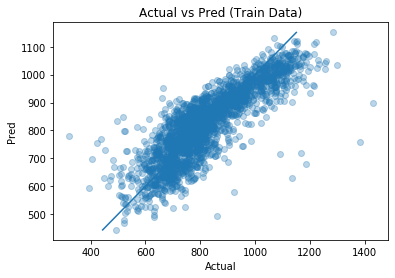

In [513]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_cross_val,clf_elastic.predict(X_cross_val),'Train')

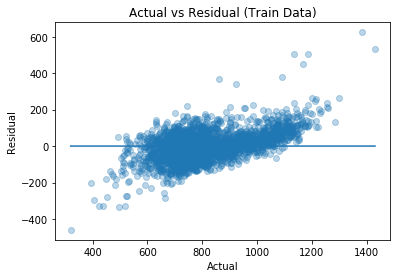

In [514]:
## Residual Plot
graph_residual(y_cross_val,y_cross_val-clf_elastic.predict(X_cross_val),'Train')

In [515]:
print("R^2 Score : ",clf_elastic.score(X_cross_val,y_cross_val))

R^2 Score :  0.7000901418024523


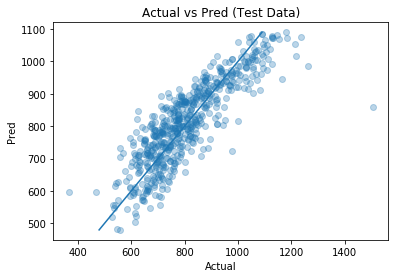

In [516]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,clf_elastic.predict(X_test),'Test')       

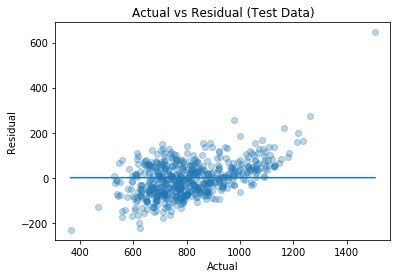

In [517]:
# Best Model Residual Graph
graph_residual(y_test,y_test- clf_elastic.predict(X_test),'Test')

In [518]:
print("R^2 Score : ",clf_elastic.score(X_test,y_test))

R^2 Score :  0.7199678096755624


#### ElasticNet - RandomGrid - Just Date

In [533]:
#Split the data 80/20 cross-validation/test
#features = list(df_merged.columns[0:5].append(df_merged.columns[6:]))
features = 'DATETIME_INT'
target = 'CRIME_COUNT'

X = np.array(df_merged[features]).reshape(-1,1)
y = df_merged[target]

X_cross_val, X_test, y_cross_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [534]:
# Define cross-validation pipelines for lasso and ridge linear regression models
elasticnet_pipeline = Pipeline([
                        ('polynomial',PolynomialFeatures()),
                        ('standard',StandardScaler()),                        
                        ('model',ElasticNet())
                        ])

In [535]:
# print parameters for lasso & ridge cross-validation pipelines
print('ElasticNet Params :\n\n',elasticnet_pipeline.get_params().keys(),'\n')

ElasticNet Params :

 dict_keys(['memory', 'steps', 'verbose', 'polynomial', 'standard', 'model', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'standard__copy', 'standard__with_mean', 'standard__with_std', 'model__alpha', 'model__copy_X', 'model__fit_intercept', 'model__l1_ratio', 'model__max_iter', 'model__normalize', 'model__positive', 'model__precompute', 'model__random_state', 'model__selection', 'model__tol', 'model__warm_start']) 



In [536]:
alphavec = 10**np.linspace(-2,2,200)
hyperparameters = {'polynomial__degree':[0,1,2],
                   #'model__alpha':[0.001,0.01,0.1,1,10,100,1000],
                   'model__alpha':alphavec,
                   'model__l1_ratio':[0,0.25,0.5,0.75,1],
                   'model__max_iter':[2000],
                   'model__normalize':[True,False],
                   'model__selection':['cyclic','random'],
                   'model__random_state':[209]}

In [537]:
clf_elastic = RandomizedSearchCV(elasticnet_pipeline,
                                 #n_iter=30,
                                 param_distributions=hyperparameters,
                                 cv=5,
                                 random_state=209,
                                 scoring='r2',
                                 verbose=2)

# clf_elastic = GridSearchCV(elasticnet_pipeline,
#                                  param_grid=hyperparameters,
#                                  cv=5,
#                                  verbose=1)

clf_elastic.fit(X_cross_val,y_cross_val);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034 
[CV]  polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034, total=   0.0s
[CV] polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034 
[CV]  polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034, total=   0.0s
[CV] polynomial__degree=1, model__selection=cyclic, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=5.941133984965034 
[CV]  polynomial__degree=1, m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18293750.381017826, tolerance: 4332.490473681378
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17818331.604941726, tolerance: 4214.428067868677
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17756564.251470074, t

[CV]  polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=0.011489510001873092, total=   0.0s
[CV] polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=0.011489510001873092 
[CV]  polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=0.011489510001873092, total=   0.0s
[CV] polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=0.011489510001873092 
[CV]  polynomial__degree=1, model__selection=random, model__random_state=209, model__normalize=True, model__max_iter=2000, model__l1_ratio=0.75, model__alpha=0.011489510001873092, total=   0.0s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


In [538]:
print("Best params : ",clf_elastic.best_params_)
print("\nCoefficients : ",clf_elastic.best_estimator_.named_steps.model.coef_)

Best params :  {'polynomial__degree': 1, 'model__selection': 'cyclic', 'model__random_state': 209, 'model__normalize': False, 'model__max_iter': 2000, 'model__l1_ratio': 1, 'model__alpha': 0.012033778407775893}

Coefficients :  [   0.         -105.07330364]


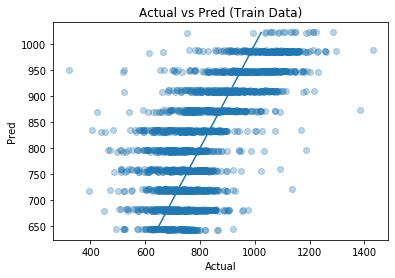

In [539]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_cross_val,clf_elastic.predict(X_cross_val),'Train')

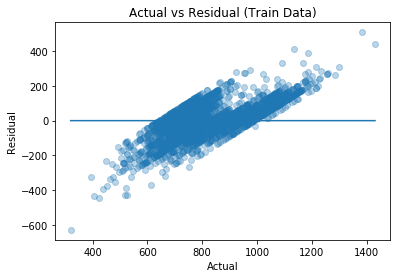

In [540]:
## Residual Plot
graph_residual(y_cross_val,y_cross_val-clf_elastic.predict(X_cross_val),'Train')

In [541]:
print("R^2 Score : ",clf_elastic.score(X_cross_val,y_cross_val))

R^2 Score :  0.4855480427290305


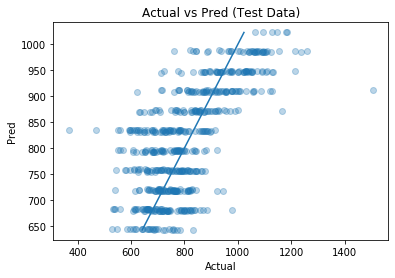

In [542]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,clf_elastic.predict(X_test),'Test')       

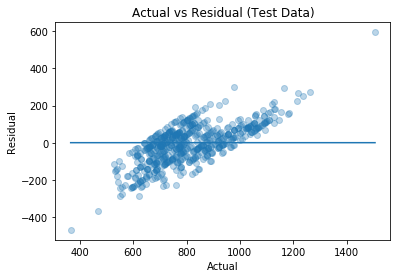

In [543]:
# Best Model Residual Graph
graph_residual(y_test,y_test-clf_elastic.predict(X_test),'Test')

In [544]:
print("R^2 Score : ",clf_elastic.score(X_test,y_test))

R^2 Score :  0.471990146504646


#### ElasticNet - RandomGrid - Date and Categoricals

In [545]:
#Split the data 80/20 cross-validation/test
#Split the data 80/20 cross-validation/test
features = list(df_merged.columns[6:])
features.append('DATETIME_INT')
target = 'CRIME_COUNT'

X = df_merged[features]
y = df_merged[target]

X_cross_val, X_test, y_cross_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [546]:
# Define cross-validation pipelines for lasso and ridge linear regression models
elasticnet_pipeline = Pipeline([
                        ('polynomial',PolynomialFeatures()),
                        ('standard',StandardScaler()),                        
                        ('model',ElasticNet())
                        ])

In [547]:
# print parameters for lasso & ridge cross-validation pipelines
print('ElasticNet Params :\n\n',elasticnet_pipeline.get_params().keys(),'\n')

ElasticNet Params :

 dict_keys(['memory', 'steps', 'verbose', 'polynomial', 'standard', 'model', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'standard__copy', 'standard__with_mean', 'standard__with_std', 'model__alpha', 'model__copy_X', 'model__fit_intercept', 'model__l1_ratio', 'model__max_iter', 'model__normalize', 'model__positive', 'model__precompute', 'model__random_state', 'model__selection', 'model__tol', 'model__warm_start']) 



In [548]:
alphavec = 10**np.linspace(-2,2,200)
hyperparameters = {'polynomial__degree':[0,1,2],
                   #'model__alpha':[0.001,0.01,0.1,1,10,100,1000],
                   'model__alpha':alphavec,
                   'model__l1_ratio':[0,0.25,0.5,0.75,1],
                   'model__max_iter':[2000],
                   'model__normalize':[True,False],
                   'model__selection':['cyclic','random'],
                   'model__random_state':[209]}

In [449]:
clf_elastic = RandomizedSearchCV(elasticnet_pipeline,
                                 #n_iter=30,
                                 param_distributions=hyperparameters,
                                 cv=5,
                                 random_state=209,
                                 scoring='r2',
                                 verbose=1)

# clf_elastic = GridSearchCV(elasticnet_pipeline,
#                                  param_grid=hyperparameters,
#                                  cv=5,
#                                  verbose=1)

clf_elastic.fit(X_cross_val,y_cross_val);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19105011.75953093, tolerance: 4332.490473681378
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18645419.42062968, tolerance: 4214.428067868677
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18717669.31500153, tolerance: 4211.692491280948
  positive)
/Users/matthewlee/anaconda3/envs/project2/l

In [450]:
print("Best params : ",clf_elastic.best_params_)
print("\nCoefficients : ",clf_elastic.best_estimator_.named_steps.model.coef_)

Best params :  {'polynomial__degree': 1, 'model__selection': 'cyclic', 'model__random_state': 209, 'model__normalize': False, 'model__max_iter': 2000, 'model__l1_ratio': 1, 'model__alpha': 0.012033778407775893}

Coefficients :  [  0.         -51.12436229  17.60386575  -4.63523656  -0.
 -12.35212915   0.29463368  -0.17148923   2.23696454  15.34453255
  -2.40867882  -1.91455685 -10.6682393    0.           3.45658959
 118.54727751]


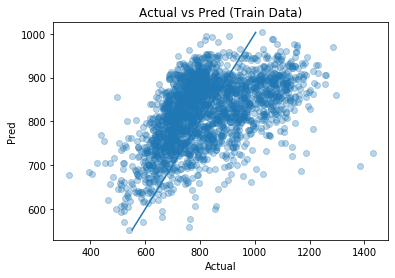

In [451]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_cross_val,clf_elastic.predict(X_cross_val),'Train')

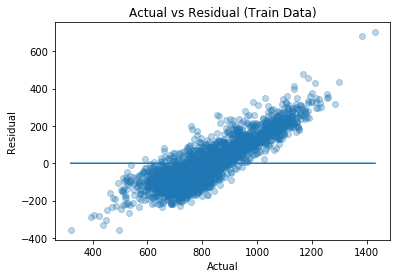

In [452]:
## Residual Plot
graph_residual(y_cross_val,y_cross_val-clf_elastic.predict(X_cross_val),'Train')

In [453]:
print("R^2 Score : ",clf_elastic.score(X_cross_val,y_cross_val))

R^2 Score :  0.25508905073117116


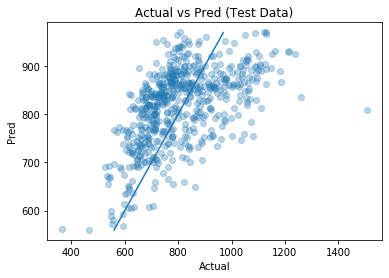

In [454]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,clf_elastic.predict(X_test),'Test')       

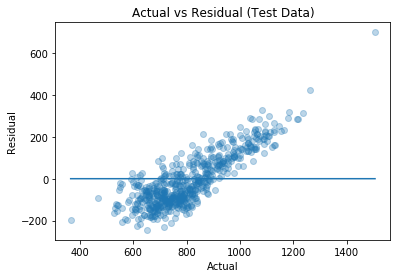

In [455]:
# Best Model Residual Graph
graph_residual(y_test,y_test- clf_elastic.predict(X_test),'Test')

In [456]:
print("R^2 Score : ",clf_elastic.score(X_test,y_test))

R^2 Score :  0.298423661396627
